<figure>
  <img style="float: left;" src="./figures/unine.png" width="200"/>
</figure>

<figure>
  <img style="float: left;" src="./figures/fair_1.png" width="200"/>
</figure>

# Fairness

Machine learning (ML) usage is increasing every day. Companies and organisations build ML models with the purpose of minimising human effort or improving performance in various tasks. So today Machine learning arguably affects our lives.

Examples:
1. Recommendation system
2. Face recognition
3. Self-driving cars
4. Candidate selection e.x college admissions, CV screening
5. Loan admissions

There are a lot of examples that researchers demonstrate inadvertently discriminating against several population groups.    
The most know is [ProPublica's](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis) research in COMPAS Dataset.

When machine learning models are being used to make decisions, they cannot be separated from the social and ethical context in which they are applied, and those developing and deploying these models must take care to do so in a manner that accounts for both performance and fairness. 

So in the last decade Fairness has become one of the most active research areas in ML.

# A2. Sources of Bias.

Bias may be introduced into a machine learning project at any step along the way, and it is important to carefully think through each potential source and how it may affect your results.


Source of bias:
- Data
    1. Historical injustice.
    2. Sample bias - Collection Bias.
    3. Limited features.
    4. Unbalanced dataset.
    5. Proxy Variables.
- Modelling
    1. Data preprocessing
    2. Model assumptions 
- Feedback loops.
    1. decisions based on biassed models lead to biassed dataset.  

<figure>
  <img style="float: left;" src="./figures/simple_pipeline.png" width="600"/>
</figure>


# A3. Load Dataset

https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"

In [3]:
def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binary target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)
    
    # Categorical dataset
    categorical_features = data.select_dtypes('category').columns
    data[categorical_features] = data.select_dtypes('category').apply(lambda x: x.cat.codes)
    return data

### load & clean dataset

In [4]:
# get and clean train dataset
TRAIN_DATA_FILE = './adult.data'#'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
train_data = train_data.dropna()
print("Train dataset shape:", train_data.shape)

# get and clean test dataset
TEST_DATA_FILE = './adult.test'#'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
test_data = test_data.dropna()
print("Test dataset shape:", test_data.shape)

Train dataset shape: (28938, 14)
Test dataset shape: (15175, 14)


In [5]:
train_data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,6,9,13,4,0,1,4,1,2174.0,0,40,38,0
1,50,5,9,13,2,3,0,4,1,0.0,0,13,38,0
2,38,3,11,9,0,5,1,4,1,0.0,0,40,38,0
3,53,3,1,7,2,5,0,2,1,0.0,0,40,38,0
4,28,3,9,13,2,9,5,2,0,0.0,0,40,4,0


### Data analysis

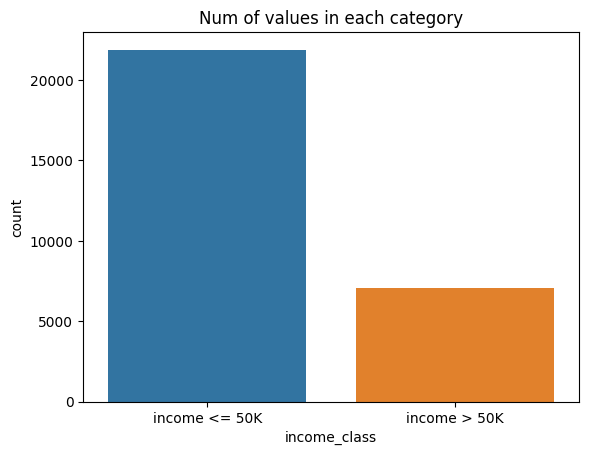

In [6]:
plt.figure()
fig = sns.countplot(x=train_data["income_class"])
fig.set_xticklabels(['income <= 50K','income > 50K'])
plt.title("Num of values in each category")
plt.show()
plt.close()

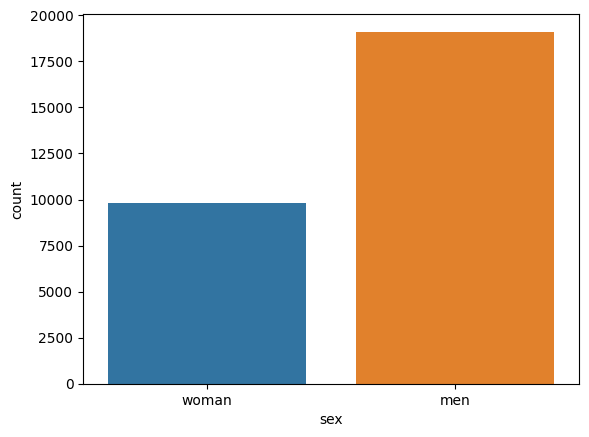

In [7]:
plt.figure()
fig = sns.countplot(x=train_data["sex"])
fig.set_xticklabels(['woman','men'])
# plt.title("gender")
plt.show()
plt.close()

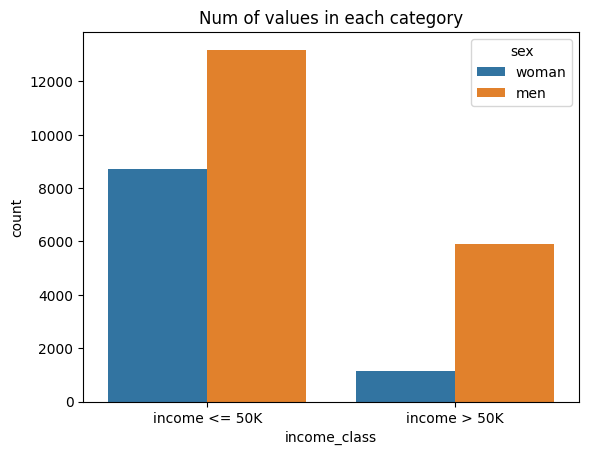

In [8]:
plt.figure()
fig = sns.countplot(data=train_data[["income_class","sex"]],
                    x="income_class",
                    hue="sex")
fig.set_xticklabels(['income <= 50K','income > 50K'])
plt.legend(title='sex', labels=['woman', 'men'])
plt.title("Num of values in each category")
plt.show()
plt.close()

The dataset is quite imbalance between a gender, so we expect our model to be unfair.
The source of the bias is coming from our societal bias.

# A4. Train a Model
let's train our model and analyse the results.

In [9]:
features = train_data.columns.difference([target_column])

# we define sex as our sensitive feature
sensitive_feature = ["sex"]

# all the rest are non sensitive feature
non_sensitive_features = list(set(features).difference(set(sensitive_feature)))

In [10]:
from sklearn.ensemble import RandomForestClassifier

model  = RandomForestClassifier(n_estimators=1000,
                                max_depth=10)

model.fit(X = train_data[sensitive_feature+non_sensitive_features],
          y = train_data[target_column])

RandomForestClassifier(max_depth=10, n_estimators=1000)

# Measure performance scores

Bellow are some of the most know mesurements scores


>1. Accuracy: $\frac{TP+TN}{TN + FP + FN + TP}$  
2. Recall: $\frac{TP}{ TP + FN }$ 
3. Precision: $\frac{TP}{ TP + FP }$  
4. F1-score: $2* \frac{ Recall * Precision}{Precision + Recall}$  

<div>
<img style="float: left;" src="./figures/conf_matrix.png" width="300"/>
</div>

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [12]:
conf_matrix = confusion_matrix(y_true = test_data[target_column],
                               y_pred = model.predict(test_data[sensitive_feature+non_sensitive_features]))
conf_matrix = pd.DataFrame(conf_matrix)

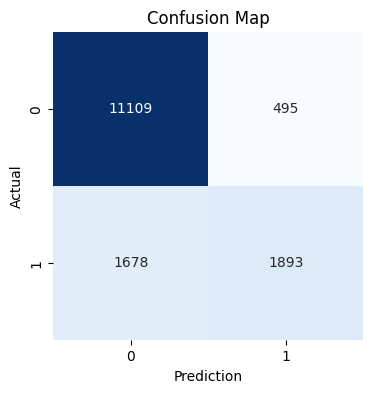

In [13]:
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cbar=False, cmap="Blues")
plt.title("Confusion Map")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [14]:
TN, FP, FN, TP = conf_matrix.values.ravel()

acc_score = ( TN + TP ) / (TN + FP + FN + TP)
precision_score = TP / (TP + FP)
recall_score = TP / (TP + FN)
f1_score = 2*(precision_score*recall_score)/(precision_score+recall_score)

print("accuracy score:", acc_score)
print("precision score:", precision_score)
print("recall score:", recall_score)
print("f1 score:", recall_score)

accuracy score: 0.8568039538714992
precision score: 0.792713567839196
recall score: 0.530103612433492
f1 score: 0.530103612433492


In [15]:
acc_score = accuracy_score(y_true = test_data[target_column],
                           y_pred = model.predict(test_data[sensitive_feature+non_sensitive_features]))
print("Accuracy_score:", acc_score)

Accuracy_score: 0.8568039538714992


# A5. Analysis of model fairness


Unfortunately there is not a single definition of fairness. There are many, often competing, ways to measure whether a given model is statistically “fair”, but it’s important to remember to start from the social and policy goals for equity and fairness and map those to the statistical properties we want in our models to help achieve those goals. Most of the definitions involve splitting the population into groups and compare metrics on those groups.

Different definition preserve different fairness aspects. So the desired fairness definition is depending on the application. In general, this requires consideration of the project’s goals, and a detailed discussion between the data scientists, decision makers, and those who will be affected by the application of the model.

Bellow we will define the most known fairness definitions.

1. **Demographic Parity** - equal positive outcome rates
2. **Equalized Opportunities** - equal true positive  rates
3. **Equalized Odds** -  equal true positive and false positive rate
4. **Predictive Parity** - equal Positive precision  
.  
.  
.  

In [16]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
predictions = pd.Series(predictions,index = test_data.index)
sensitive_atribute = test_data[sensitive_feature[0]]

In [17]:
woman_mask = sensitive_atribute == 0
conf_matrix_0 = confusion_matrix(y_true = test_data.loc[woman_mask,target_column],
                                 y_pred = predictions.loc[woman_mask])
conf_matrix_0 = pd.DataFrame(conf_matrix_0)

In [18]:
man_mask = sensitive_atribute == 1
conf_matrix_1 = confusion_matrix(y_true = test_data.loc[man_mask,target_column],
                                 y_pred = predictions.loc[man_mask])
conf_matrix_1 = pd.DataFrame(conf_matrix_1)

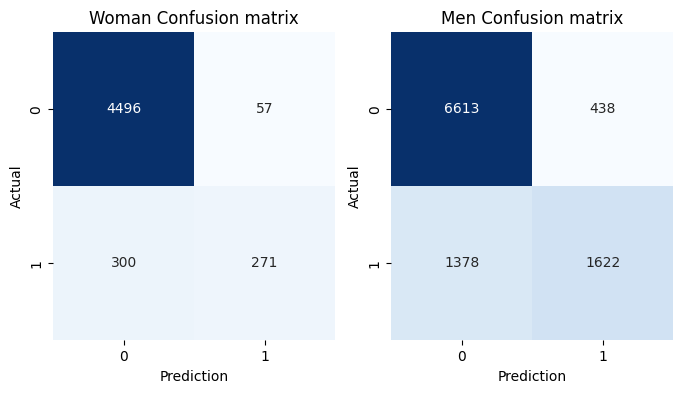

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (8,4))
sns.heatmap(conf_matrix_0, annot=True, fmt='g', cbar=False, cmap="Blues", ax=axes[0])
axes[0].set_title("Woman Confusion matrix")
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Prediction')

sns.heatmap(conf_matrix_1, annot=True, fmt='g', cbar=False, cmap="Blues", ax=axes[1])
axes[1].set_title("Men Confusion matrix")
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Prediction')
plt.show()
plt.close()

## F1.  Demographic Parity

**Demographic parity** , also referred to as **statistical parity** , **acceptance rate parity**  and **benchmarking**

Demographic Parity states that the positive outcome rates between sensitive group must be the same.

---------------
> **Definition Demographic Parity :** A classifier $C$ is said that satisfy **demographic parity** if $$ P_c(\hat{Y}= 1 | S = s ) =  P_c(\hat{Y} = 1), \quad  \forall s\in S $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we can also equivalent write:
$$ P_c(\hat{Y}= 1 | S = 0 ) =  P_c(\hat{Y}= 1 | S = 1 ) $$  
---------------

**How to measure Demographic parity?**

we can measure the Demographic parity using the Demographic parity difference metric.

> **Demographic parity difference :** we can measure the demographic parity using the next formula:
  $$  \text{Metric} =  max_s[P_c(\hat{Y}= 1 | S = s )] -  min_s[P_c(\hat{Y}= 1 | S = s )] $$  

In [20]:
def demographic_parity_difference(predictions, sensitive_attribute):
    """
    Implementation of demographic parity difference for different groups of sensitive attribute
    1. For each group calculate the propotion of accepted rate.
    2. Find the maximum and the minim group.
    3. Calcaulte the difference.
    """
    # 1. For each group calculate the proportion of accepted rate.
    unique_groups = np.sort(sensitive_attribute.unique())
    proportion_of_accepted_rate = []
    for group in unique_groups:
        pred_group = predictions[sensitive_attribute==group]
        accepted_rate = (pred_group==1).sum() / pred_group.shape[0]
        proportion_of_accepted_rate += [accepted_rate]

    # 2. Find the maximum and the minimum accepted_rate.
    maximum_accepted_rate = max(proportion_of_accepted_rate)
    minimum_accepted_rate = min(proportion_of_accepted_rate)

    # 3. Calculate the different.
    difference = maximum_accepted_rate - minimum_accepted_rate
    
    return difference, proportion_of_accepted_rate

In [21]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sensitive_attribute = test_data["sex"]

In [22]:
demographic_metric, rates = demographic_parity_difference(predictions, sensitive_attribute)

In [23]:
print(f"Demographic parity difference is: {round(demographic_metric,5)}")

Demographic parity difference is: 0.14094


In [24]:
print(f"The rate of different groups are: {rates}")

The rate of different groups are: [0.06401249024199844, 0.20495473087255]


---------------
**When to use demographic parity?** 
1. We are aware of **historical biases** that may have affected the quality of our data. E.x not presents of specific minority in a specific work.
2. We want to **change the state of our current world to improve it**. For example, we want to have equal admitions of different group in a specific project.


**Potential issues?** 
1. **Laziness**: We can satisfy demographic parity in we accept random people in group S=0 but qualified people in group  b unless we have the same proportion of positive outcome. We avoid lasyness because classfication is usually perfomred by optimizing an perfomance metric.
2. **Not optimality compatible**: A classifier that satisfy demographic parity is suboptimal, if the dataset demographic parity is not hold.
---------------

## F2. Equalized Opotunities

**Equalized Opportunities** , also referred to as **true positive parity**, **sensitivity**.

Equalized Opportunities states that each group has equal true positive rates.

---------------
> **Definition Equalized Opotunities :** A classifire $C$ is said that satisfy **equalized opotunities** if $$ P_c(\hat{Y} = 1 | S = s, Y = 1 ) =  P_c(\hat{Y} = 1 | Y = 1), \quad  \forall s\in S $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we can also equivalent write:
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$  
---------------

**How to measure Equalized Opportunities?**

we can measure the equalized Opportunities using the equalized opportunities difference metric.

> **equalized opportunities difference :** we can measure the equalized opportunities using the next formula:
  $$  \text{Metric} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] $$  

**Hint**

> **True Positive Rate** : To calculate the $P_c(\hat{Y}= 1 | Y = 1 )$ you can do the following:
  $$  P_c(\hat{Y}= 1 | Y = 1 ) = \frac{P_c(\hat{Y}= 1, Y = 1 )}{P_c( Y = 1 )} = \frac{TP}{P} = \frac{TP}{TP+FN} $$ 

In [25]:
def equalized_opportunities_difference(predictions, actual, sensitive_attribute):
    """
    Implementation of equalized opportunities difference for different groups of sensitive attribute
    1. For each group calculate the TPR.
    2. Find the maximum and the minim group.
    3. Calculate the difference.
    """
    # 1. For each group calculate the TPR.
    unique_groups = np.sort(sensitive_attribute.unique())
    true_positive_rates = []
    for group in unique_groups:
        pred_group = predictions[sensitive_attribute==group]
        actual_group = actual[sensitive_attribute==group]
        conf_matrix = confusion_matrix(y_true = actual_group,
                                       y_pred = pred_group)
        TN, FP, FN, TP = conf_matrix.ravel()
        
        true_positive_rate = TP / (TP + FN)
        true_positive_rates += [true_positive_rate]

    # 2. Find the maximum and the minimum accepted_rate.
    maximum_tpr = max(true_positive_rates)
    minimum_tpr = min(true_positive_rates)

    # 3. Calculate the different.
    difference = maximum_tpr - minimum_tpr
    
    return difference, true_positive_rates

In [26]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sensitive_attribute = test_data["sex"]
actual = test_data[target_column]

In [27]:
equalized_opportunities_metric, _ = equalized_opportunities_difference(predictions, actual, sensitive_attribute)

In [28]:
print(f"equalized opportunities difference is: {round(equalized_opportunities_metric,5)}")

equalized opportunities difference is: 0.06606


---------------
**When to use equalized opportunities?**
1. When is a strong emphasis on predicting the positive outcome correctly. e.x college admissions
2. When False Positives are not costly for the stakeholder. e.x spam detection

**Potential issues?** 
1. **Not optimality compatible**: A classifier that satisfy demographic parity is suboptimal, if the dataset demographic parity is not hold.
---------------

## F3. Equalized Odds

**Equalized Odds** , also referred to as

Equalized Odds states that the true positive rates (TPR) and false positive rates (FPR) between sensitive group must be the same.

- TPR = TP / total_positives  = TP / (TP+FN)
- FPR = FP / total_negatives = FP / (FP+TN)
---------------
> **Definition Equalized Odds :** A classifier $C$ is said that satisfy **equalized odds** if $$ P_c(\hat{Y} = 1 | S = s, Y = y ) =  P_c(\hat{Y} = 1 | Y = y), \quad  \forall s\in S, \forall y\in Y $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we want to satisfy both:
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$ 
and 
$$ P_c(\hat{Y}= 1 | S = 0, Y = 0 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 0 ) $$  
---------------

**How to measure Equalized Opportunities?**

we can measure the equalized Opportunities using the equalized opportunities difference metric.

> **equalized opportunities difference :** we can measure the equalized opportunities using the next formula:
  $$   \text{Metric} = \text{true_positive_rate_difference} + \text{false_positive_rate_difference}  $$
where
  $$ \text{true_positive_rate_difference} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] $$ 
  $$ \text{false_positive_rate_difference} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 0 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 0 )] $$  

In [29]:
def equalized_odds_difference(predictions, actual, sensitive_attribute):
    """
    Implementation of equalized odds difference for different groups of sensitive attribute
    1. For each group calculate the TPR.
    2. Find the maximum and the minim group.
    3. Calcaulte the difference.
    """
    # 1. For each group calculate the TPR.
    unique_groups = np.sort(sensitive_attribute.unique())
    true_positive_rates = []
    false_positive_rates = []
    for group in unique_groups:
        pred_group = predictions[sensitive_attribute==group]
        actual_group = actual[sensitive_attribute==group]
        conf_matrix = confusion_matrix(y_true = actual_group,
                                       y_pred = pred_group)
        TN, FP, FN, TP = conf_matrix.ravel()
        
        true_positive_rate = TP / (TP + FN)
        false_positive_rate = FP / (FP + TN)
        
        true_positive_rates += [true_positive_rate]
        false_positive_rates += [false_positive_rate]

    # 2. Find the maximum and the minimum accepted_rate.
    maximum_tpr = max(true_positive_rates)
    minimum_tpr = min(true_positive_rates)
    
    maximum_fpr = max(false_positive_rates)
    minimum_fpr = min(false_positive_rates)

    # 3. Calculate the different.
    difference_tpr = maximum_tpr - minimum_tpr
    difference_fpr = maximum_fpr - minimum_fpr
    difference = difference_tpr + difference_fpr
    
    return difference, (true_positive_rates,false_positive_rates)

In [30]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sensitive_attribute = test_data["sex"]
actual = test_data[target_column]

In [31]:
equalized_odds_metrics, _ = equalized_odds_difference(predictions, actual, sensitive_attribute)

In [32]:
print(f"equalized odds difference is: {round(equalized_odds_metrics,5)}")

equalized odds difference is: 0.11566


In [33]:
results = pd.DataFrame([acc_score,
                        precision_score,
                        recall_score,
                        f1_score,
                        demographic_metric,
                        equalized_opportunities_metric,
                        equalized_odds_metrics], 
                       index = ["accuracy",
                                "precision",
                                "recall",
                                "f1_score",
                                "demographic_metric",
                                "equalized_opportunities",
                                "equalized_odds"],
                       columns = ["model"])

----------------
**When to use equalized odds?** 
1. When is a strong emphasis on predicting the positive outcome correctly. e.x college admissions
2. When we strongly care about minimising costly False Positives

**Potential issues?** 
1. **Not optimality compatible**: A classifier that satisfy equalized odds is suboptimal, if the dataset demographic parity is not hold. Its more constrained than the equal opportunities, so the effect on perforce will be stronger
---------------

For your project you have explained why you choose the specific fairness criteria.

In [34]:
def compute_metric(y_pred, y_true, sensitive_feature):
    
    conf_matrix = confusion_matrix(y_true = y_true,
                                   y_pred = y_pred)
    conf_matrix = pd.DataFrame(conf_matrix)

    TN, FP, FN, TP = conf_matrix.values.ravel()

    acc_score = ( TN + TP ) / (TN + FP + FN + TP)
    precision_score = TP  / (TP + FP)
    recall_score = TP  / (TP + FN)
    f1_score = 2*(precision_score*recall_score)/(precision_score+recall_score)
    
    demographic_metric, _ = demographic_parity_difference(y_pred,
                                                          sensitive_feature)
    
    equalized_opportunities_metric, _ = equalized_opportunities_difference(y_pred,
                                                                           y_true,
                                                                          sensitive_feature)
    equalized_odds_metrics, _ = equalized_odds_difference(y_pred,
                                                          y_true,
                                                          sensitive_feature)
    
    return {
            "accuracy": acc_score,
            "precision": precision_score,
            "recall": recall_score,
            "f1_score": f1_score,
            "demographic_metric": demographic_metric,
            "equalized_opportunities" : equalized_opportunities_metric,
            "equalized_odds": equalized_odds_metrics
            }

# B. Correct the unfair Clasifier

In summary there are 3 general methods to correct an unfair clasifier.

1. **Pre-Processing**: make changes in the data before training the model i.e remove correleted features
2. **In-Processing**: make changes in the model to correct fairness i.e add aditional loss terms to ensure fairness.
3. **Post-Processing**: make changes after the model's output i.e fix classification threshold.


<div>
<img style="float: left;" src="./figures/corect_unfairness.png" width="400"/>
</div>

# B1. Pre-Processing

# B1.1 Unawareness
A very intuitive but **wrong solution** is to assume that ignoring the sensitive feature we can build a fair classifier.
This approach is wrong because other feature may be correlated with our sensitive features.

We will build a **Unawareness** classifier and the compare the results with our previous classifier.

In [35]:
from sklearn.ensemble import RandomForestClassifier

unaware_model  = RandomForestClassifier(n_estimators=1000,
                                        max_depth=10)

unaware_model.fit(X = train_data[non_sensitive_features],
                  y = train_data[target_column])

RandomForestClassifier(max_depth=10, n_estimators=1000)

In [36]:
unaware_model.predict(test_data[non_sensitive_features])

array([0, 0, 0, ..., 1, 0, 1])

In [37]:
unaware_metrics = compute_metric(y_pred = unaware_model.predict(test_data[non_sensitive_features]),
                                 y_true = test_data[target_column],
                                 sensitive_feature = test_data["sex"])

In [38]:
unaware_results = pd.DataFrame(unaware_metrics,
                               index = ["unaware_model"]).T

In [39]:
unaware_results

,unaware_model
accuracy,0.857595
precision,0.796717
recall,0.530104
f1_score,0.636624
demographic_metric,0.140632
equalized_opportunities,0.066061
equalized_odds,0.115043


## Compare the results of 2 models

In [40]:
all_results = pd.concat([results, unaware_results],axis=1)
all_results

,model,unaware_model
accuracy,0.856804,0.857595
precision,0.792714,0.796717
recall,0.530104,0.530104
f1_score,0.635342,0.636624
demographic_metric,0.140942,0.140632
equalized_opportunities,0.066061,0.066061
equalized_odds,0.115660,0.115043


### Conclusion
Our conclusion is that we are not able to vanish unfairness by excluding sensitive features.  
The reason in that some other feature leak information about our sensitive attribute.

## B.2 Post processing
From the above results we expect that our sensitive feature are correlate with non-sensitive feature in our analysis.
We will try to find and exclude also those feature in order to improve our fairness properties.

In [41]:
corr = {}
for f in non_sensitive_features:
    corr[f] =np.corrcoef(test_data[sensitive_feature[0]], test_data[f])[0,1]
corr = np.abs(pd.DataFrame(data=corr, index=["corr"]).T).sort_values(by="corr",ascending = False)

<Figure size 640x480 with 0 Axes>

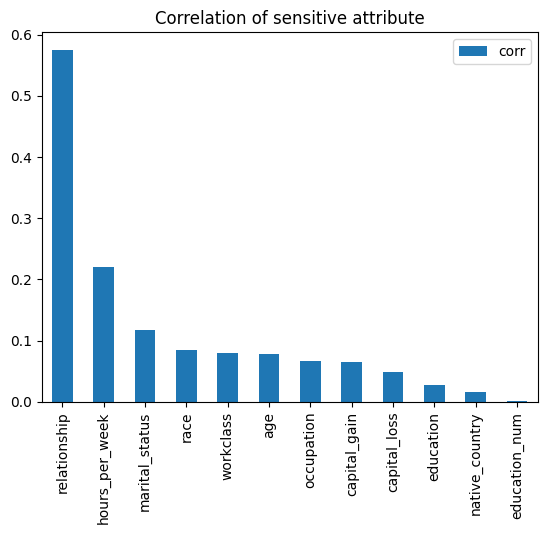

In [42]:
plt.figure()
corr.plot(kind="bar")
plt.title("Correlation of sensitive attribute")
plt.show()
plt.close()

#### build classifier excluding k most correlated feature

In [43]:
k=3
k_most_correlated = corr.iloc[0:k].index.values.tolist()

In [44]:
for i in range(len(k_most_correlated)):
    print(f"===========iteration{i+1}===========")
    training_features = list(set(non_sensitive_features).difference(set(k_most_correlated[0:i+1])))
    print("We exclude from training: ", k_most_correlated[0:i+1])
    
    # 1. train
    post_processing_model  = RandomForestClassifier(n_estimators=1000,
                                                    max_depth=10)

    post_processing_model.fit(X = train_data[training_features],
                              y = train_data[target_column])
    

    # 2. compute matrix
    post_processing_metrics = compute_metric(y_pred= post_processing_model.predict(test_data[training_features]),
                                             y_true= test_data[target_column],
                                             sensitive_feature = test_data["sex"])
    
    # 3. append result
    post_processing_results = pd.DataFrame(post_processing_metrics,
                                           index = [f"post_prossesing_{i+1}"]).T
    
    all_results = pd.concat([all_results, post_processing_results],axis=1)

===========iteration1===========
We exclude from training:  ['relationship']
===========iteration2===========
We exclude from training:  ['relationship', 'hours_per_week']
===========iteration3===========
We exclude from training:  ['relationship', 'hours_per_week', 'marital_status']


In [45]:
all_results

,model,unaware_model,post_prossesing_1,post_prossesing_2,post_prossesing_3
accuracy,0.856804,0.857595,0.856409,0.854102,0.833871
precision,0.792714,0.796717,0.799742,0.783299,0.842243
recall,0.530104,0.530104,0.520022,0.525343,0.361803
f1_score,0.635342,0.636624,0.630239,0.628897,0.506170
demographic_metric,0.140942,0.140632,0.146162,0.141049,0.068056
equalized_opportunities,0.066061,0.066061,0.102008,0.070817,0.026245
equalized_odds,0.115660,0.115043,0.153497,0.121290,0.026951


<AxesSubplot: >

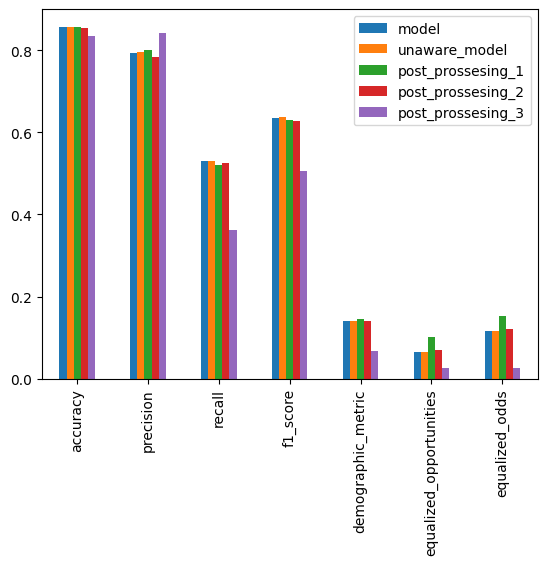

In [46]:
all_results.plot(kind="bar")

In [47]:
all_results

,model,unaware_model,post_prossesing_1,post_prossesing_2,post_prossesing_3
accuracy,0.856804,0.857595,0.856409,0.854102,0.833871
precision,0.792714,0.796717,0.799742,0.783299,0.842243
recall,0.530104,0.530104,0.520022,0.525343,0.361803
f1_score,0.635342,0.636624,0.630239,0.628897,0.506170
demographic_metric,0.140942,0.140632,0.146162,0.141049,0.068056
equalized_opportunities,0.066061,0.066061,0.102008,0.070817,0.026245
equalized_odds,0.115660,0.115043,0.153497,0.121290,0.026951


# B2. Post-Processing

In [48]:
propa = model.predict_proba(test_data[sensitive_feature+non_sensitive_features])

In [49]:
ts = np.linspace(0,1,50)

In [50]:
p = propa[:, 1]

In [51]:
metric_ts = []
for t in ts:
    class_1_mask = p >= t
    
    prediction = pd.Series(class_1_mask * 1,index=test_data.index)
    
    metrics = compute_metric(y_pred = prediction,
                             y_true = test_data[target_column],
                             sensitive_feature = test_data[sensitive_feature[0]])
    
    metric_ts += [metrics]

/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_82560/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)


In [52]:
ts_results = pd.DataFrame(metric_ts,index = ts)

In [53]:
ts_results

,accuracy,precision,recall,f1_score,demographic_metric,equalized_opportunities,equalized_odds
0.000000,0.235321,0.235321,1.000000,0.380988,0.000000,0.000000,0.000000
0.020408,0.463130,0.304478,0.997760,0.466575,0.202811,0.000582,0.181477
0.040816,0.569951,0.352383,0.987679,0.519440,0.334621,0.029111,0.336101
0.061224,0.630774,0.387411,0.978997,0.555141,0.378643,0.045878,0.387093
0.081633,0.666161,0.411213,0.969476,0.577481,0.380622,0.065814,0.396894
0.102041,0.696079,0.434055,0.959395,0.597697,0.373076,0.074661,0.387574
0.122449,0.723690,0.457984,0.949314,0.617880,0.380504,0.089761,0.402484
0.142857,0.743591,0.477240,0.939513,0.632959,0.378262,0.109364,0.411523
0.163265,0.756969,0.491301,0.925231,0.641803,0.375319,0.129888,0.423132
0.183673,0.768501,0.504488,0.912910,0.649855,0.368894,0.140237,0.422302


<AxesSubplot: >

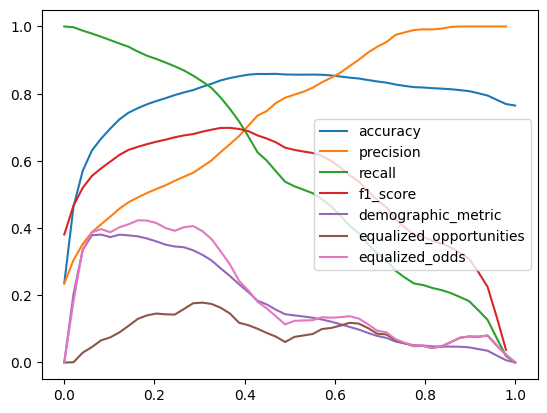

In [54]:
ts_results.plot()

# different classification theshold for each group

# implement roc curve

In [55]:
def roc_curve(y_true, scores, thresholds):
    """
    Custom impementation of roc curve for binary clasification.
    """
    number_of_positives = (y_true == 1).sum()
    tpr, fpr, ppr = [], [], []
    for thr in thresholds:
        prediction_thr = (scores > thr) * 1

        conf_matrix = confusion_matrix(y_true = y_true,
                                   y_pred = prediction_thr)
    
        TN, FP, FN, TP = conf_matrix.ravel()    
        tpr += [TP / (TP + FN)]
        fpr += [FP / (FP + TN)]
        ppr += [(TP+ FP) / (TN + FP + FN+ TP)]
    
    return fpr, tpr, ppr, thresholds

In [56]:
predicted_propabilities = model.predict_proba(test_data[sensitive_feature+non_sensitive_features])[:, 1]
predicted_propabilities = pd.Series(predicted_propabilities,
                                    index=test_data.index)

In [57]:
thresholds = np.linspace(0.0, 1.0, 100)
fpr, tpr, ppr, thresholds = roc_curve(y_true= test_data[target_column].values, 
                                      scores= predicted_propabilities.values, 
                                      thresholds= thresholds)

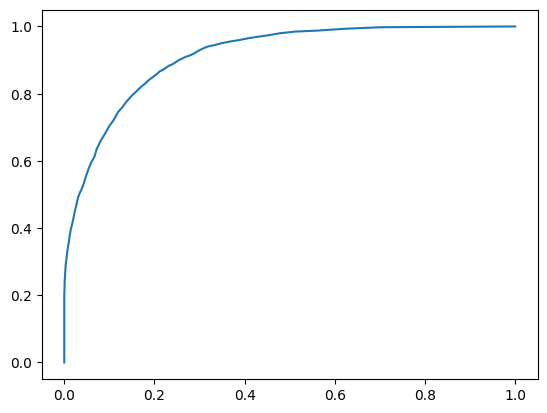

In [59]:
plt.plot(fpr,tpr)

# Calculate roc curve for different groups

In [60]:
mask_group_0 = test_data["sex"] == 0
mask_group_1 = np.logical_not(mask_group_0)

# group s=0
y_true_group_0 = test_data.loc[mask_group_0, target_column].values
scores_group_0 = predicted_propabilities.loc[mask_group_0].values
fpr_group_0, tpr_group_0, ppr_group_0, _ = roc_curve(y_true = y_true_group_0,
                                                     scores = scores_group_0,
                                                     thresholds = thresholds)

# group s=1
y_true_group_1 = test_data.loc[mask_group_1,target_column].values
scores_group_1 = predicted_propabilities.loc[mask_group_1].values
fpr_group_1, tpr_group_1, ppr_group_1, _ = roc_curve(y_true = y_true_group_1,
                                                     scores = scores_group_1,
                                                     thresholds = thresholds)

## 1. positive predictive rate for different groups

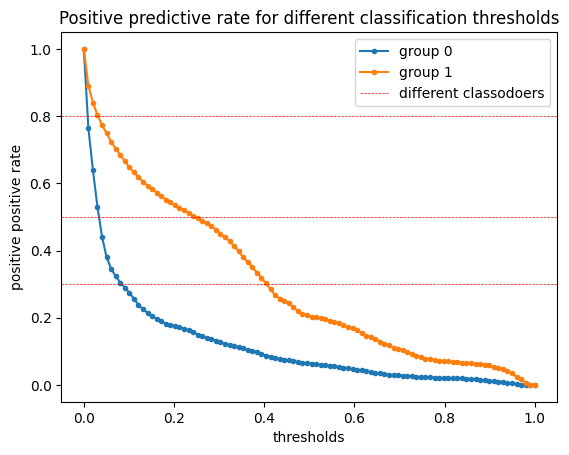

In [63]:
plt.figure()
plt.plot(thresholds, ppr_group_0, linestyle='-', marker='.', label = "group 0")
plt.plot(thresholds, ppr_group_1, linestyle='-', marker=".", label = "group 1")
plt.axhline(y = 0.8, color = 'r', linestyle = '--', linewidth = 0.5, label = "different classodoers")
plt.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth = 0.5)
plt.axhline(y = 0.3, color = 'r', linestyle = '--', linewidth = 0.5)
plt.ylabel("positive positive rate")
plt.xlabel("thresholds")
plt.title("Positive predictive rate for different classification thresholds")
plt.legend()
plt.show()
plt.close()

## 2. Roc curve for different groups

In [64]:
# !pip install intersect
from intersect import intersection

x, y = intersection(fpr_group_0, tpr_group_0, fpr_group_1, tpr_group_1)
x, y

(array([1.00000000e+00, 4.81159640e-03, 2.45634442e-03, 6.58906216e-04,
        9.19670754e-20]),
 array([1.        , 0.30254383, 0.26604492, 0.22530225, 0.1558669 ]))

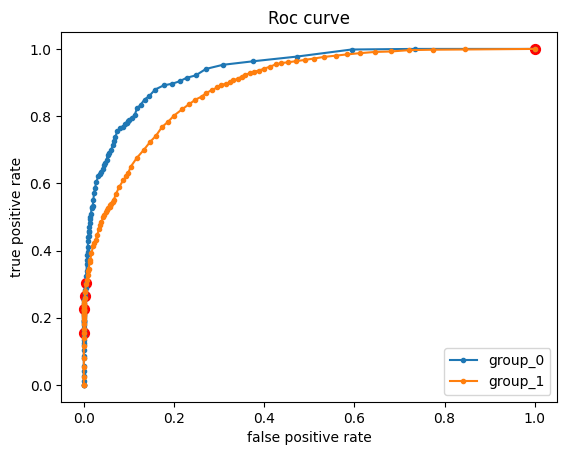

In [65]:
plt.figure()
plt.plot(fpr_group_0, tpr_group_0, linestyle='-', marker='.', label = "group_0")
plt.plot(fpr_group_1, tpr_group_1, linestyle='-', marker=".", label = "group_1")
plt.scatter(x, y, color="r",s = 50)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("Roc curve")
plt.legend()
plt.show()
plt.close()

In [66]:
def get_close_thresholds(metrics_group_0, metrics_group_1, error, thresholds_list):
    fpr_group_0, tpr_group_0 = metrics_group_0
    fpr_group_1, tpr_group_1 = metrics_group_1
    
    fpr_error = pd.DataFrame(np.abs(np.subtract.outer(fpr_group_0, fpr_group_1))) 
    tpr_error = pd.DataFrame(np.abs(np.subtract.outer(tpr_group_0, tpr_group_1)))
    error_matrix = fpr_error + tpr_error
    
    accepted_error_matrix = pd.melt(error_matrix < error, ignore_index =False)
    thresholds = accepted_error_matrix[accepted_error_matrix["value"]==True]
    thresholds.reset_index(inplace=True)
    thresholds = thresholds.rename({"index":"thr_group_0",
                       "variable":"thr_group_1"},
                      axis=1)
    
    theshold_pair = [(thresholds_list[i],thresholds_list[j]) for i,j in thresholds[["thr_group_0","thr_group_1"]].values]
    return theshold_pair, thresholds

In [67]:
accepted_threholds, thresholds_indexs = get_close_thresholds(metrics_group_0=(fpr_group_0, tpr_group_0),
                                                             metrics_group_1=(fpr_group_1, tpr_group_1),
                                                             error = 0.01,
                                                             thresholds_list=thresholds)

In [68]:
def predict_whit_different_thesholds(predicted_propabilities, mask_group_0, thr0, mask_group_1 ,thr1):
    thr_series_0 = mask_group_0 *  thr0
    thr_series_1 = mask_group_1 * thr1
    thr = thr_series_0 + thr_series_1
    
    prediction = predicted_propabilities > thr
    return prediction

In [69]:
metric_ts = []
for (thr0, thr1) in accepted_threholds:
    predictions = predict_whit_different_thesholds(predicted_propabilities = predicted_propabilities,
                                     mask_group_0 = mask_group_0 ,
                                     thr0=thr0,
                                     mask_group_1 = mask_group_1 ,
                                     thr1=thr1)
    
    metrics = compute_metric(y_pred = predictions,
                             y_true = test_data[target_column],
                             sensitive_feature = test_data[sensitive_feature[0]])
    
    metric_ts += [metrics]

/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_82560/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)
/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_82560/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)
/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_82560/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)
/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_82560/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)
/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_82560/4292309794.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = TP  / (TP + FP)
/var/folders/cr/h97h0km17v725pm92zr1lrk80000gn/T/ipykernel_82560/4292309794.py:10: RuntimeWarning: invalid value en

In [70]:
results_for_different_thr = pd.DataFrame(metric_ts)

In [71]:
results_for_different_thr

,accuracy,precision,recall,f1_score,demographic_metric,equalized_opportunities,equalized_odds
0,0.235321,0.235321,1.000000,0.380988,0.000000,0.000000,0.000000
1,0.843558,0.909091,0.372445,0.528407,0.073368,0.000696,0.007992
2,0.839012,0.923423,0.344441,0.501734,0.067111,0.005579,0.009924
3,0.838023,0.926437,0.338561,0.495898,0.064425,0.001421,0.004916
4,0.836310,0.935846,0.326799,0.484433,0.063074,0.003340,0.006734
...,...,...,...,...,...,...,...
70,0.764679,NaN,0.000000,NaN,0.000000,0.000000,0.000000
71,0.764679,NaN,0.000000,NaN,0.000000,0.000000,0.000000
72,0.764679,NaN,0.000000,NaN,0.000000,0.000000,0.000000
73,0.764679,NaN,0.000000,NaN,0.000000,0.000000,0.000000


In [72]:
results_for_different_thr["f1_score"].idxmax()

1

In [73]:
best_model = results_for_different_thr.loc[[1]]

In [74]:
best_model.rename(index={1: 'post-prossesing equalized odds'},inplace=True)

In [75]:
best_model

,accuracy,precision,recall,f1_score,demographic_metric,equalized_opportunities,equalized_odds
post-prossesing equalized odds,0.843558,0.909091,0.372445,0.528407,0.073368,0.000696,0.007992


In [76]:
all_results = pd.concat([all_results, best_model.T],axis=1)

<AxesSubplot: >

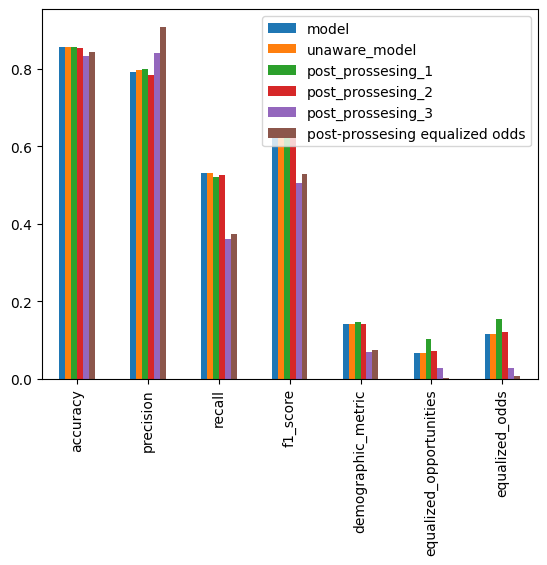

In [81]:
all_results.plot(kind="bar")

In [204]:
all_results

,model,unaware_model,post_prossesing_1,post_prossesing_2,post_prossesing_3,accuracy,precision,recall,f1_score,demographic_metric,equalized_opportunities,equalized_odds,post-prossesing equalized odds
accuracy,0.856870,0.857002,0.856474,0.853641,0.833740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839539
precision,0.793046,0.793957,0.800604,0.780316,0.843381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.921365
recall,0.530104,0.529824,0.519462,0.526183,0.360403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.347802
f1_score,0.635448,0.635539,0.630095,0.628533,0.505003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.504981
demographic_metric,0.141432,0.140445,0.146254,0.142048,0.067555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.066051
equalized_opportunities,0.066061,0.063643,0.103426,0.071817,0.026663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005014
equalized_odds,0.116241,0.113037,0.154851,0.123347,0.026943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009204
